# Bank Churn Prediction
<br>
The dataset contains information about bank customers about their financial history and personal information. There is a label column for those who have churned. 


**The objective of this project is to create a model to detect customers who may churn.**

In [1]:
# Dependences
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler 
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.svm  import SVC
from sklearn.metrics import roc_curve, roc_auc_score, f1_score, confusion_matrix, make_scorer
import itertools

## Loading Data

The data is located in the 'Data' folder in the same project directory

In [2]:
# Current directory 
current_dir = os.getcwdb().decode()
# Path to data
data_path = os.path.join(current_dir,'../Data/')
# Files in folder
files = os.listdir(data_path)
# Csv file
data_file = [elem for elem in files if elem.startswith('data')]
# CSV path
path = data_path + data_file[0]
# Save 'data' as a DataFrame
data = pd.read_csv(path)
# Firts 5 samples
data.head()

CLIENTNUM     Attrition_Flag  Customer_Age Gender  Dependent_count  \
0  768805383  Existing Customer            45      M                3   
1  818770008  Existing Customer            49      F                5   
2  713982108  Existing Customer            51      M                3   
3  769911858  Existing Customer            40      F                4   
4  709106358  Existing Customer            40      M                3   

  Education_Level Marital_Status Income_Category Card_Category  \
0     High School        Married     $60K - $80K          Blue   
1        Graduate         Single  Less than $40K          Blue   
2        Graduate        Married    $80K - $120K          Blue   
3     High School        Unknown  Less than $40K          Blue   
4      Uneducated        Married     $60K - $80K          Blue   

   Months_on_book  ...  Months_Inactive_12_mon  Contacts_Count_12_mon  \
0              39  ...                       1                      3   
1              44  ...                       1                      2   
2              36  ...                       1                      0   
3              34  ...                       4                      1   
4              21  ...                       1                      0   

   Credit_Limit  Total_Revolving_Bal  Avg_Open_To_Buy  Total_Amt_Chng_Q4_Q1  \
0       12691.0                  777          11914.0                 1.335   
1        8256.0                  864           7392.0                 1.541   
2        3418.0                    0           3418.0                 2.594   
3        3313.0                 2517            796.0                 1.405   
4        4716.0                    0           4716.0                 2.175   

   Total_Trans_Amt  Total_Trans_Ct  Total_Ct_Chng_Q4_Q1  Avg_Utilization_Ratio  
0             1144              42                1.625                  0.061  
1             1291              33                3.714                  0.105  
2             1887              20                2.333                  0.000  
3             1171              20                2.333                  0.760  
4              816              28                2.500                  0.000  

[5 rows x 21 columns]

## Columns references
<br>

- **CLIENTNUM:** Client number. Unique identifier for the customer holding the account

- **Attrition_Flag:** Internal event (customer activity) variable - if the account is closed then 1 else 0
- **Customer_Age:** Demographic variable - Customer's Age in Years
- **Gender**: Demographic variable - M=Male, F=Female
- **Dependent_count:** Demographic variable - Number of dependents
- **Education_Level:** Demographic variable - Educational Qualification of the account holder (example: high school, college graduate, etc.)
- **Marital_Status:** Demographic variable - Married, Single, Divorced, Unknown
- **Income_Category:** Demographic variable - Annual Income Category of the account holder (< 40K - 60K, 80K, 120K, >
- **Card_Category:** Product Variable - Type of Card (Blue, Silver, Gold, Platinum)
- **Months_on_book:** Period of relationship with bank
- **Total_Relationship_Count:** Total no. of products held by the customer
- **Months_Inactive_12_mon:** No. of months inactive in the last 12 months
- **Contacts_Count_12_mon:** No. of Contacts in the last 12 months
- **Credit_Limit:** Credit Limit on the Credit Card
- **Total_Revolving_Bal:** Total Revolving Balance on the Credit Card
- **Avg_Open_To_Buy:** Open to Buy Credit Line (Average of last 12 months)
- **Total_Amt_Chng_Q4_Q1:** Change in Transaction Amount (Q4 over Q1)
- **Total_Trans_Amt:** Total Transaction Amount (Last 12 months)
- **Total_Trans_Ct:** Total Transaction Count (Last 12 months)
- **Total_Ct_Chng_Q4_Q1:** Change in Transaction Count (Q4 over Q1)
- **Avg_Utilization_Ratio:** Average Card Utilization Ratio

As mentioned above, the column called 'CLIENTNUM' is an unique identifier for each customer, so it will be set as the dataframe index

In [3]:
# Set CLIENTNUM column as the dataframe's index
data.set_index('CLIENTNUM', 
               inplace = True)

In [4]:
# Save the data shape
shape = data.shape

print(f"The data contains {shape[1]} columns and {shape[0]} samples")

The data contains 20 columns and 10127 samples


Let's to save the columns in three variables:

- y_col: Is the predict column name.
- object_columns: Are the categoric columns in the dataframe.
- numeric_columns: Are the numeric columns in the dataframe.
<br>

These variables will make easier the selection of columns in graphics and data processing

In [5]:
# Column to predict
y_col = 'Attrition_Flag'
# Object type columns
object_columns = data.select_dtypes('object').columns.drop(y_col).to_list()
# Numeric type columns
numeric_columns = data.select_dtypes(np.number).columns.to_list()

## Data types

The dataframe contains 6 categoric columns (one of them is the column to predict) and 14 numeric columns

In [6]:
# Data types 
for (col, dtype) in dict(data.dtypes).items():
    print((f"- {col: <25}: {dtype}"))

- Attrition_Flag           : object
- Customer_Age             : int64
- Gender                   : object
- Dependent_count          : int64
- Education_Level          : object
- Marital_Status           : object
- Income_Category          : object
- Card_Category            : object
- Months_on_book           : int64
- Total_Relationship_Count : int64
- Months_Inactive_12_mon   : int64
- Contacts_Count_12_mon    : int64
- Credit_Limit             : float64
- Total_Revolving_Bal      : int64
- Avg_Open_To_Buy          : float64
- Total_Amt_Chng_Q4_Q1     : float64
- Total_Trans_Amt          : int64
- Total_Trans_Ct           : int64
- Total_Ct_Chng_Q4_Q1      : float64
- Avg_Utilization_Ratio    : float64


## Categoric Columns

Let's to analyze the categoric columns through pie charts to visualize the categories and their proportions to extract a bit of information of the dataset.

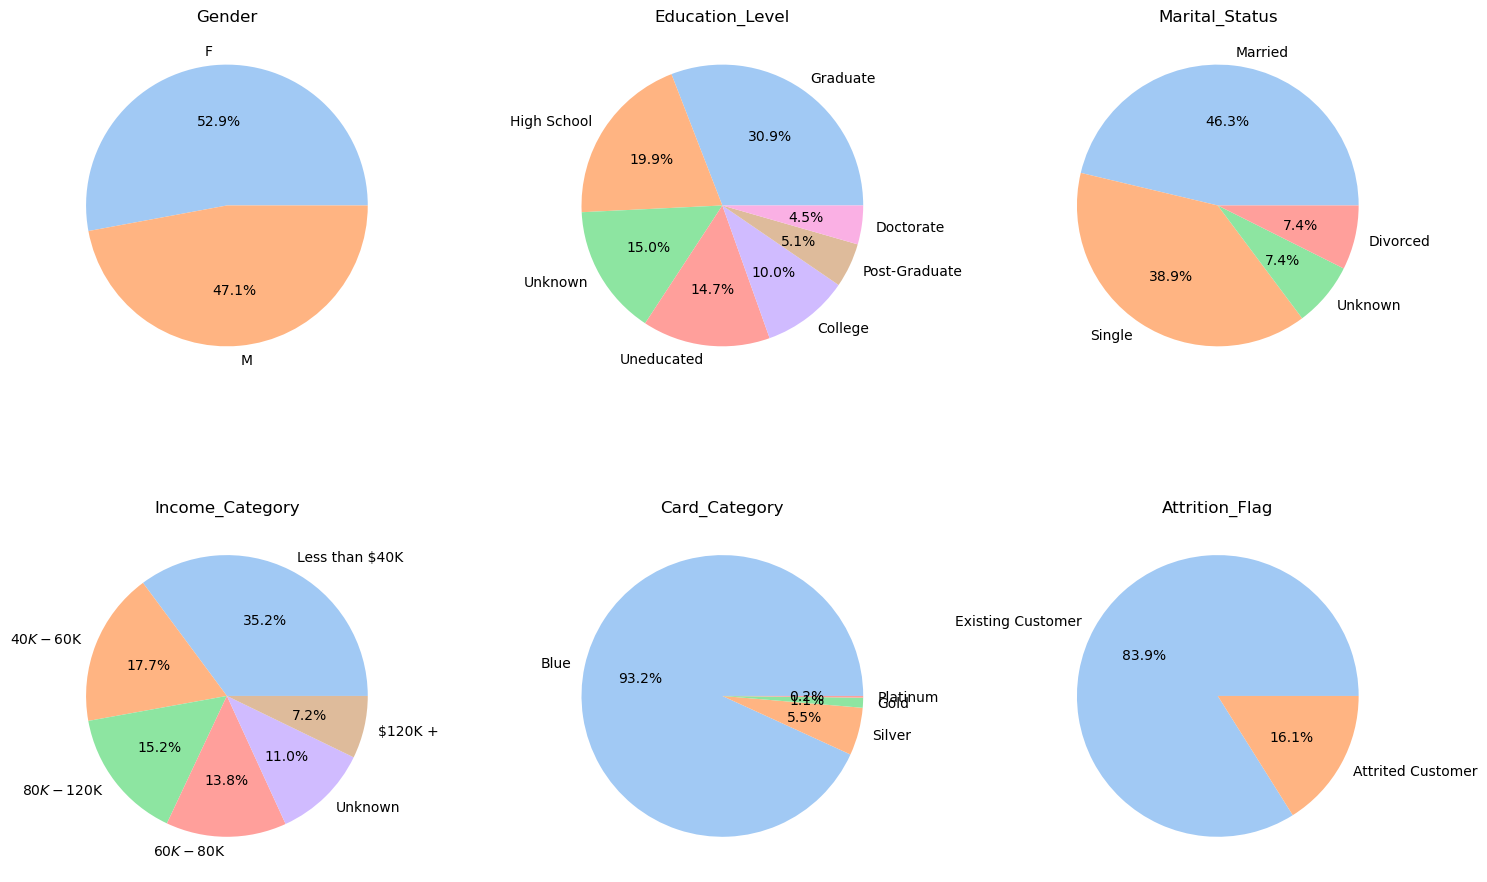

In [7]:
# Create 2 rows and 3 columns of subplots 
fig, axes = plt.subplots(2, 3, 
                         figsize = (15, 10)
                        )
# Plot the pie charts
for i, col in enumerate(object_columns + [y_col]):
    # Column selection
    column = data[col]
    # Color for each category
    colors = sns.color_palette('pastel')[0: len(column.unique())]
    # Percentage for each category
    values = column.value_counts()
    # ax selection
    ax = axes[i // 3, i % 3]  
    # pie chart
    ax.pie(x = values.values,
           labels = values.index,
           colors = colors, 
           autopct = '%1.1f%%')
    # Title
    ax.set_title(col)  
# Fit the space between the charts
plt.tight_layout()
# Show the plot
plt.show()

Some information from the charts:
- There is almost the same proportion between mens and womens.
- A bit more of 70% of the customers have received any level of education.
- Almost the 50% of them are married.
- The income category has a pyramid shape, the proportion are decreasing as the income is higher.
- The most frequent card is the Blue one.
- The 16% of the customers have close their accounts

There are 'Unknown' values in some columns.

I want to see how the categorical variables in the data set are related to the customer attrition rate. Customer attrition is the outcome variable that I want to predict. To do this, I will plot the frequency of each category for each value of customer attrition.  

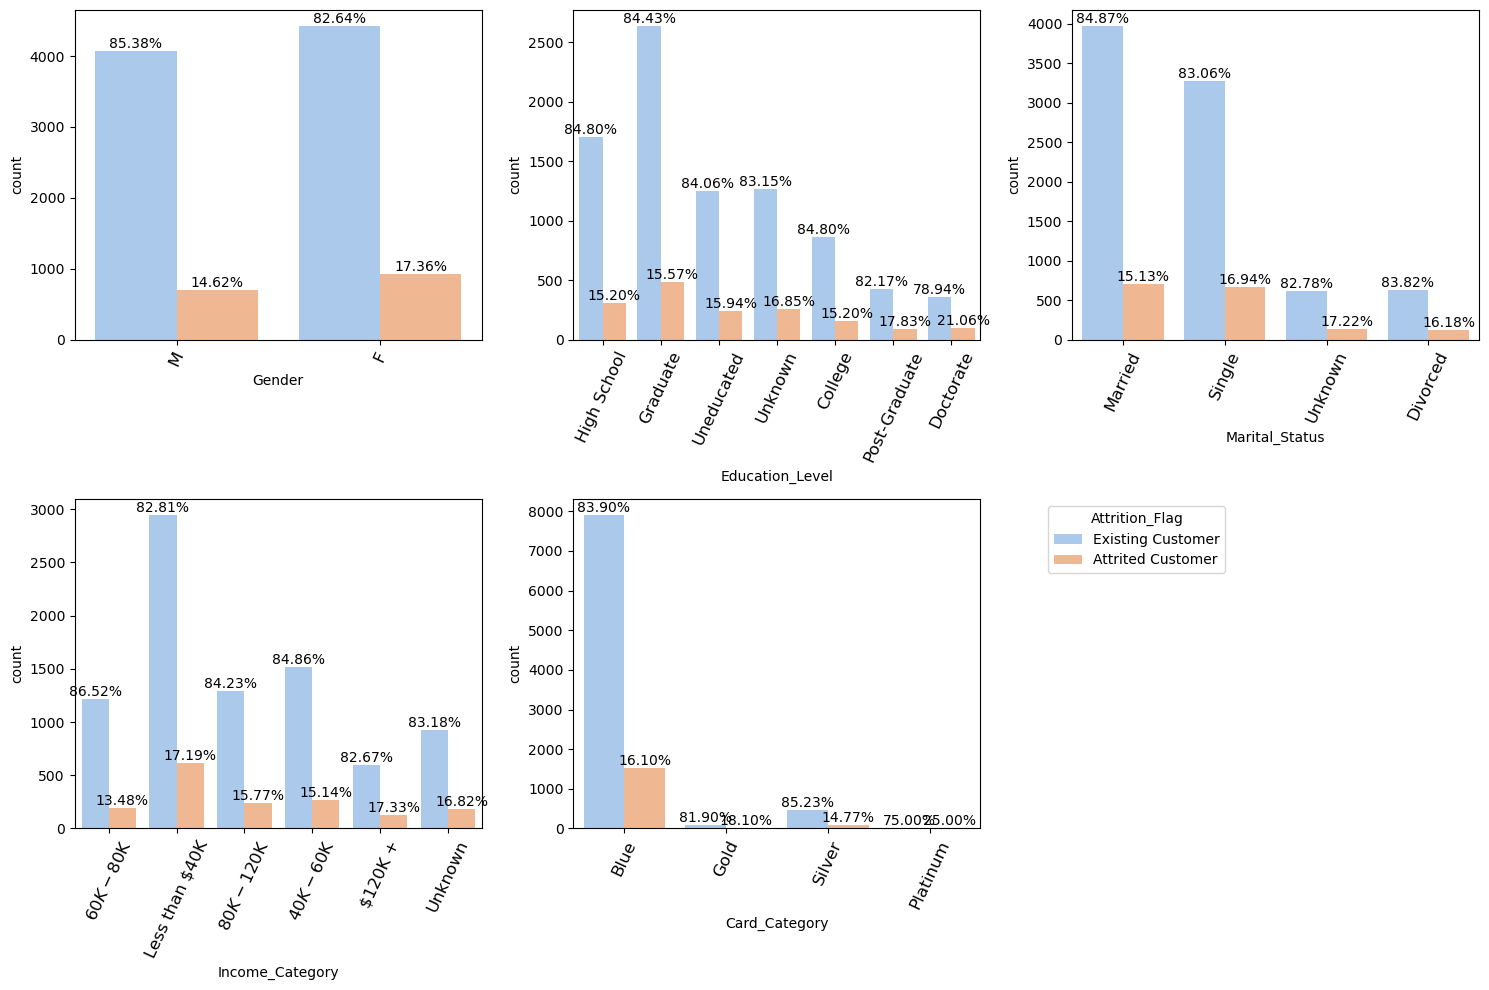

In [8]:
# Create 2 rows and 3 columns of subplots
fig, axes = plt.subplots(2, 3, 
                         figsize = (15, 10)
                        )
# Color selection
colors = sns.color_palette('pastel')[:2]

# Plot the 'countplots'
for i, col in enumerate(object_columns):
    # Select the axes
    ax = axes[i // 3, i % 3]  
    # Select the column
    pair = data[[col, y_col]]
    # Create the Plot the 'countplots' using 'y_col' as hue
    sns.countplot(x = col,
                  hue = y_col,
                  data = pair,
                  palette = colors,
                  ax = ax)
    # Rotate the X labels
    ax.set_xticklabels(ax.get_xticklabels(),
                       rotation = 65,
                       fontsize = 12)
    # Add proportions for each category in the column
    for i, patches in enumerate(ax.patches):
        # h represents the number of categories in the column
        h = int(len(ax.patches) / 2)
        # 'lag' allows to calculate the proportion when 'y_col' takes the value 0 or 1
        # for each category
        lag = h if i < h else -h
        # Bar height
        height = patches.get_height()
        # number of samples for the category
        subtotal = height + ax.patches[i + lag].get_height()
        # Create the proportions for each category
        ax.annotate(f'{height / subtotal:.2%}',
                    (patches.get_x() + patches.get_width() / 2., height),
                    ha = 'center', va = 'bottom',
                   fontsize = 10)
    # Delete the legends 
    ax.get_legend().remove()
        
# Delete empty plot
fig.delaxes(axes[1, 2])

# Fit the space between the charts
plt.tight_layout()
# Add same legend for all graphics
plt.legend(title = "Attrition_Flag",
           bbox_to_anchor = (1.15, 1), 
           loc = 'upper left')
# Show the plot
plt.show()

There is not a clear pattern, the churn rate fluctuates between 14% and 17% for each category.


## Numeric Columns

To analyze the numeric columns, I'm going to plot their distributions and their relationship with the other columns, segmented by each label in 'Attrition_Flag'. The pairplot method in Seaborn make this easier.

For a clear visualization, the first 7 numeric columns are plotted first and the rest in the next graphic:

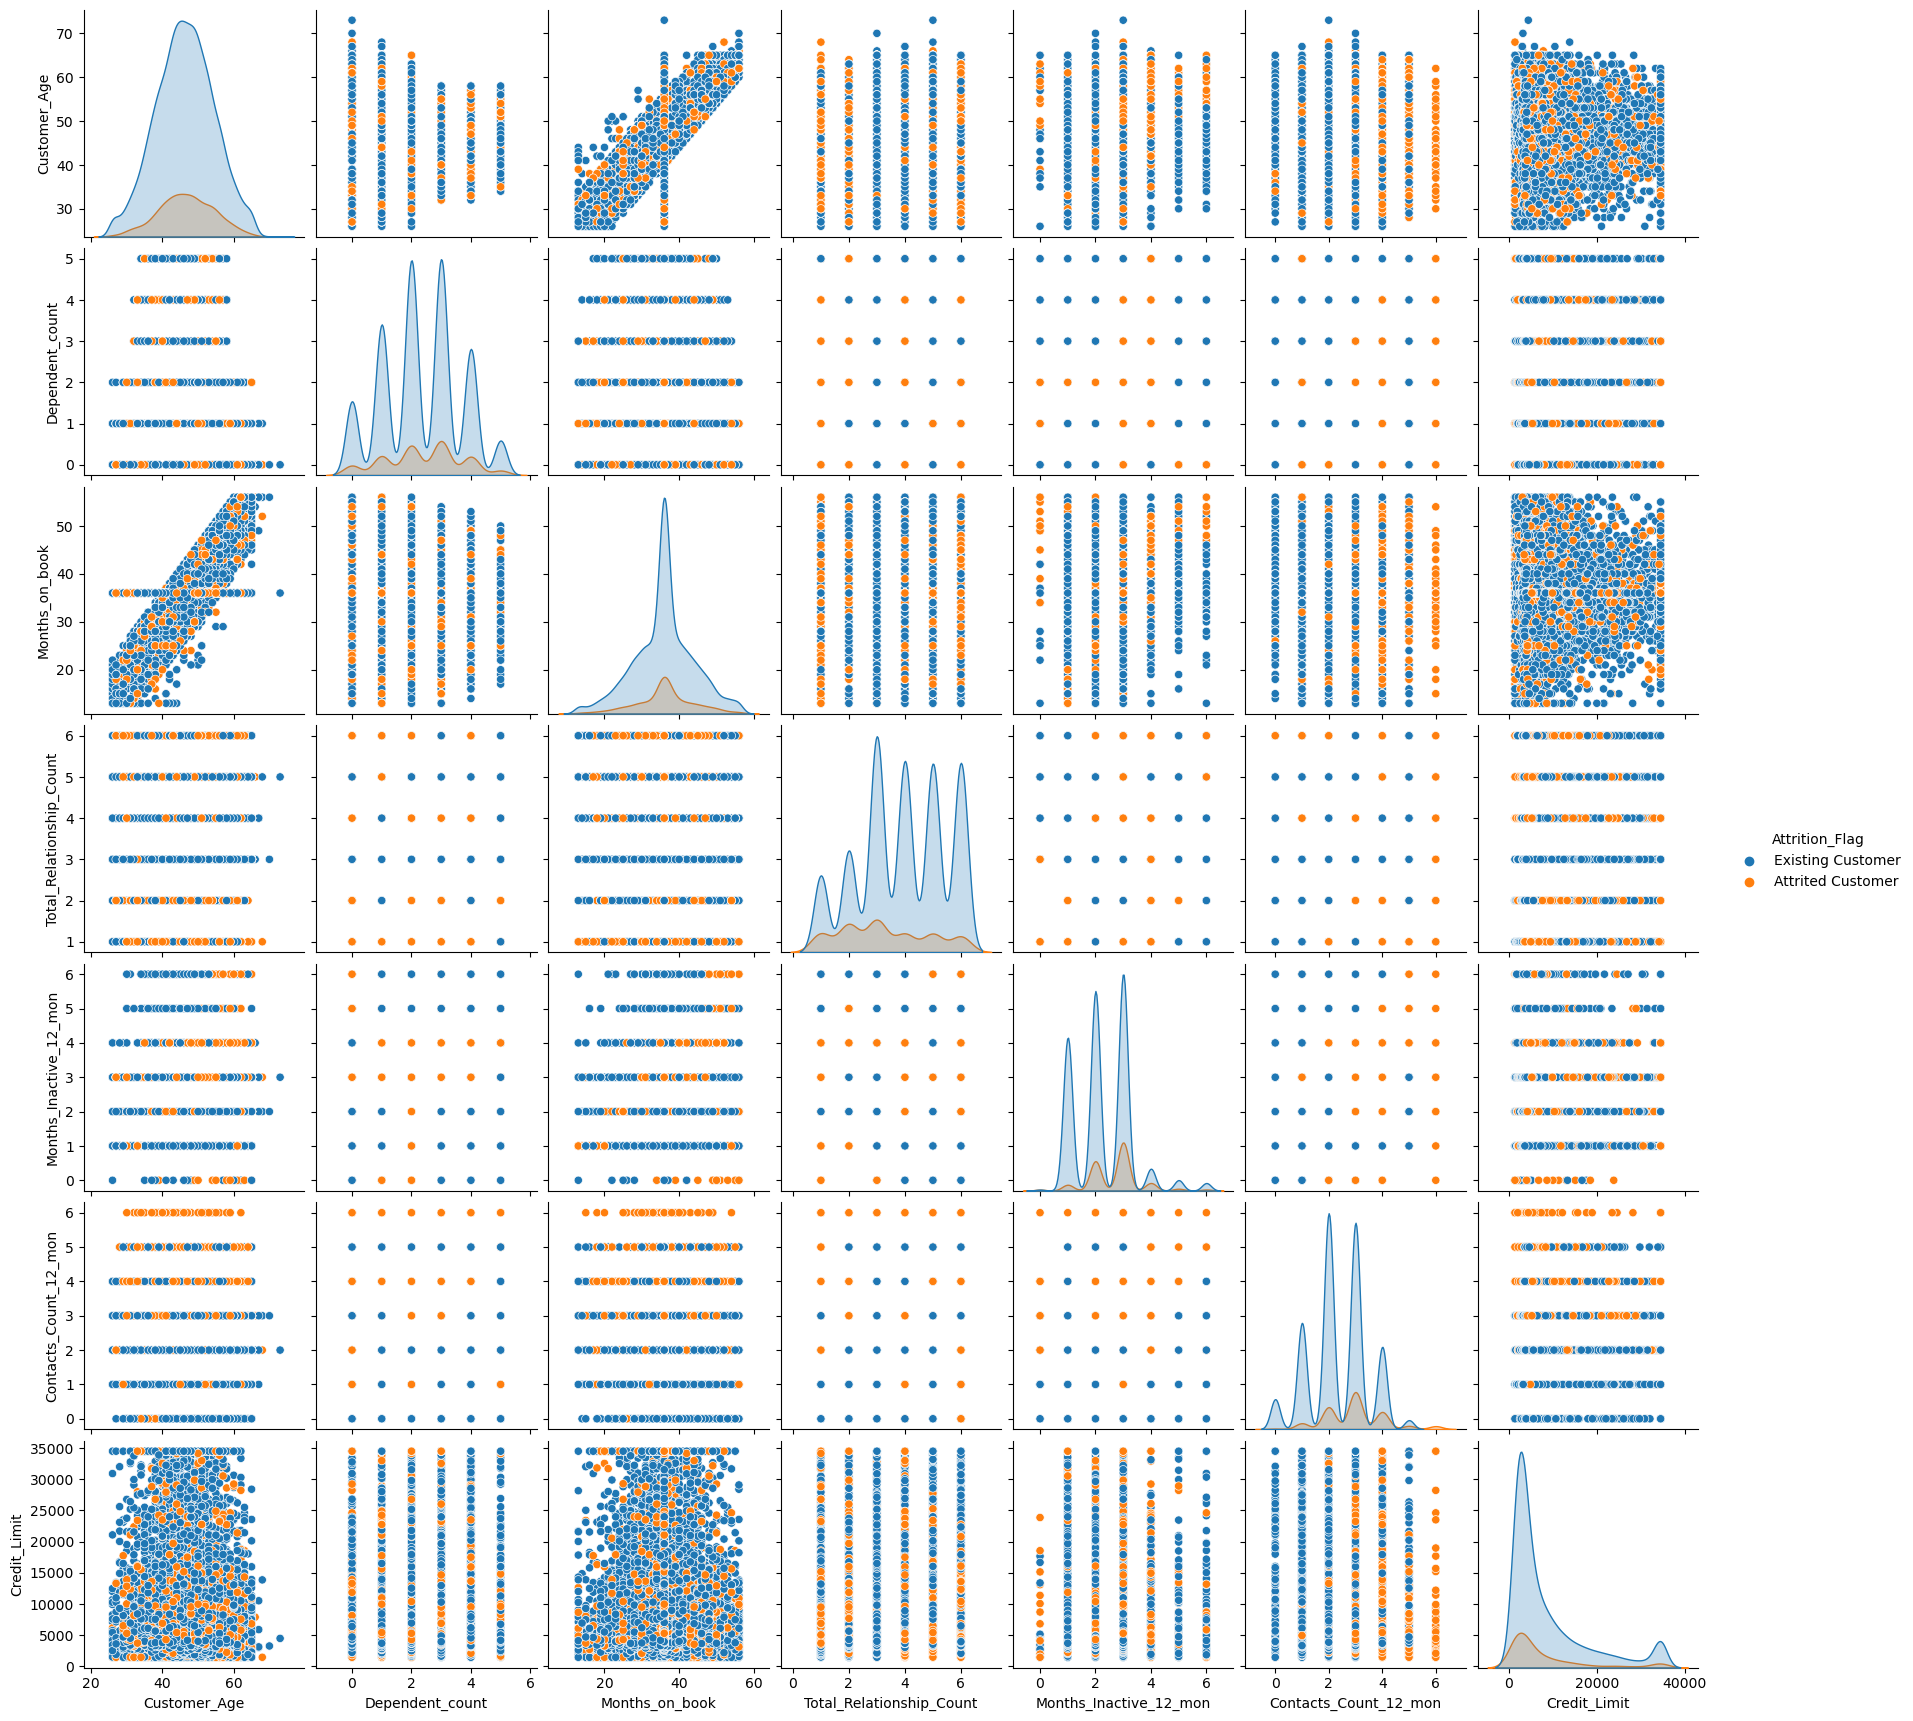

In [9]:
# Create pairplots for the firs 7 numeric columns using 'y_col' as 'hue' 
sns.pairplot(data[numeric_columns[:7] + [y_col]], 
             hue = y_col)
# Show the plot
plt.show()

For the first 7 columns, there is a similar distribution for 'existing' and 'attrited' customers and relationship with the other columns doesn't show any pattern to identify where the 'attrited customers' are located.

[]

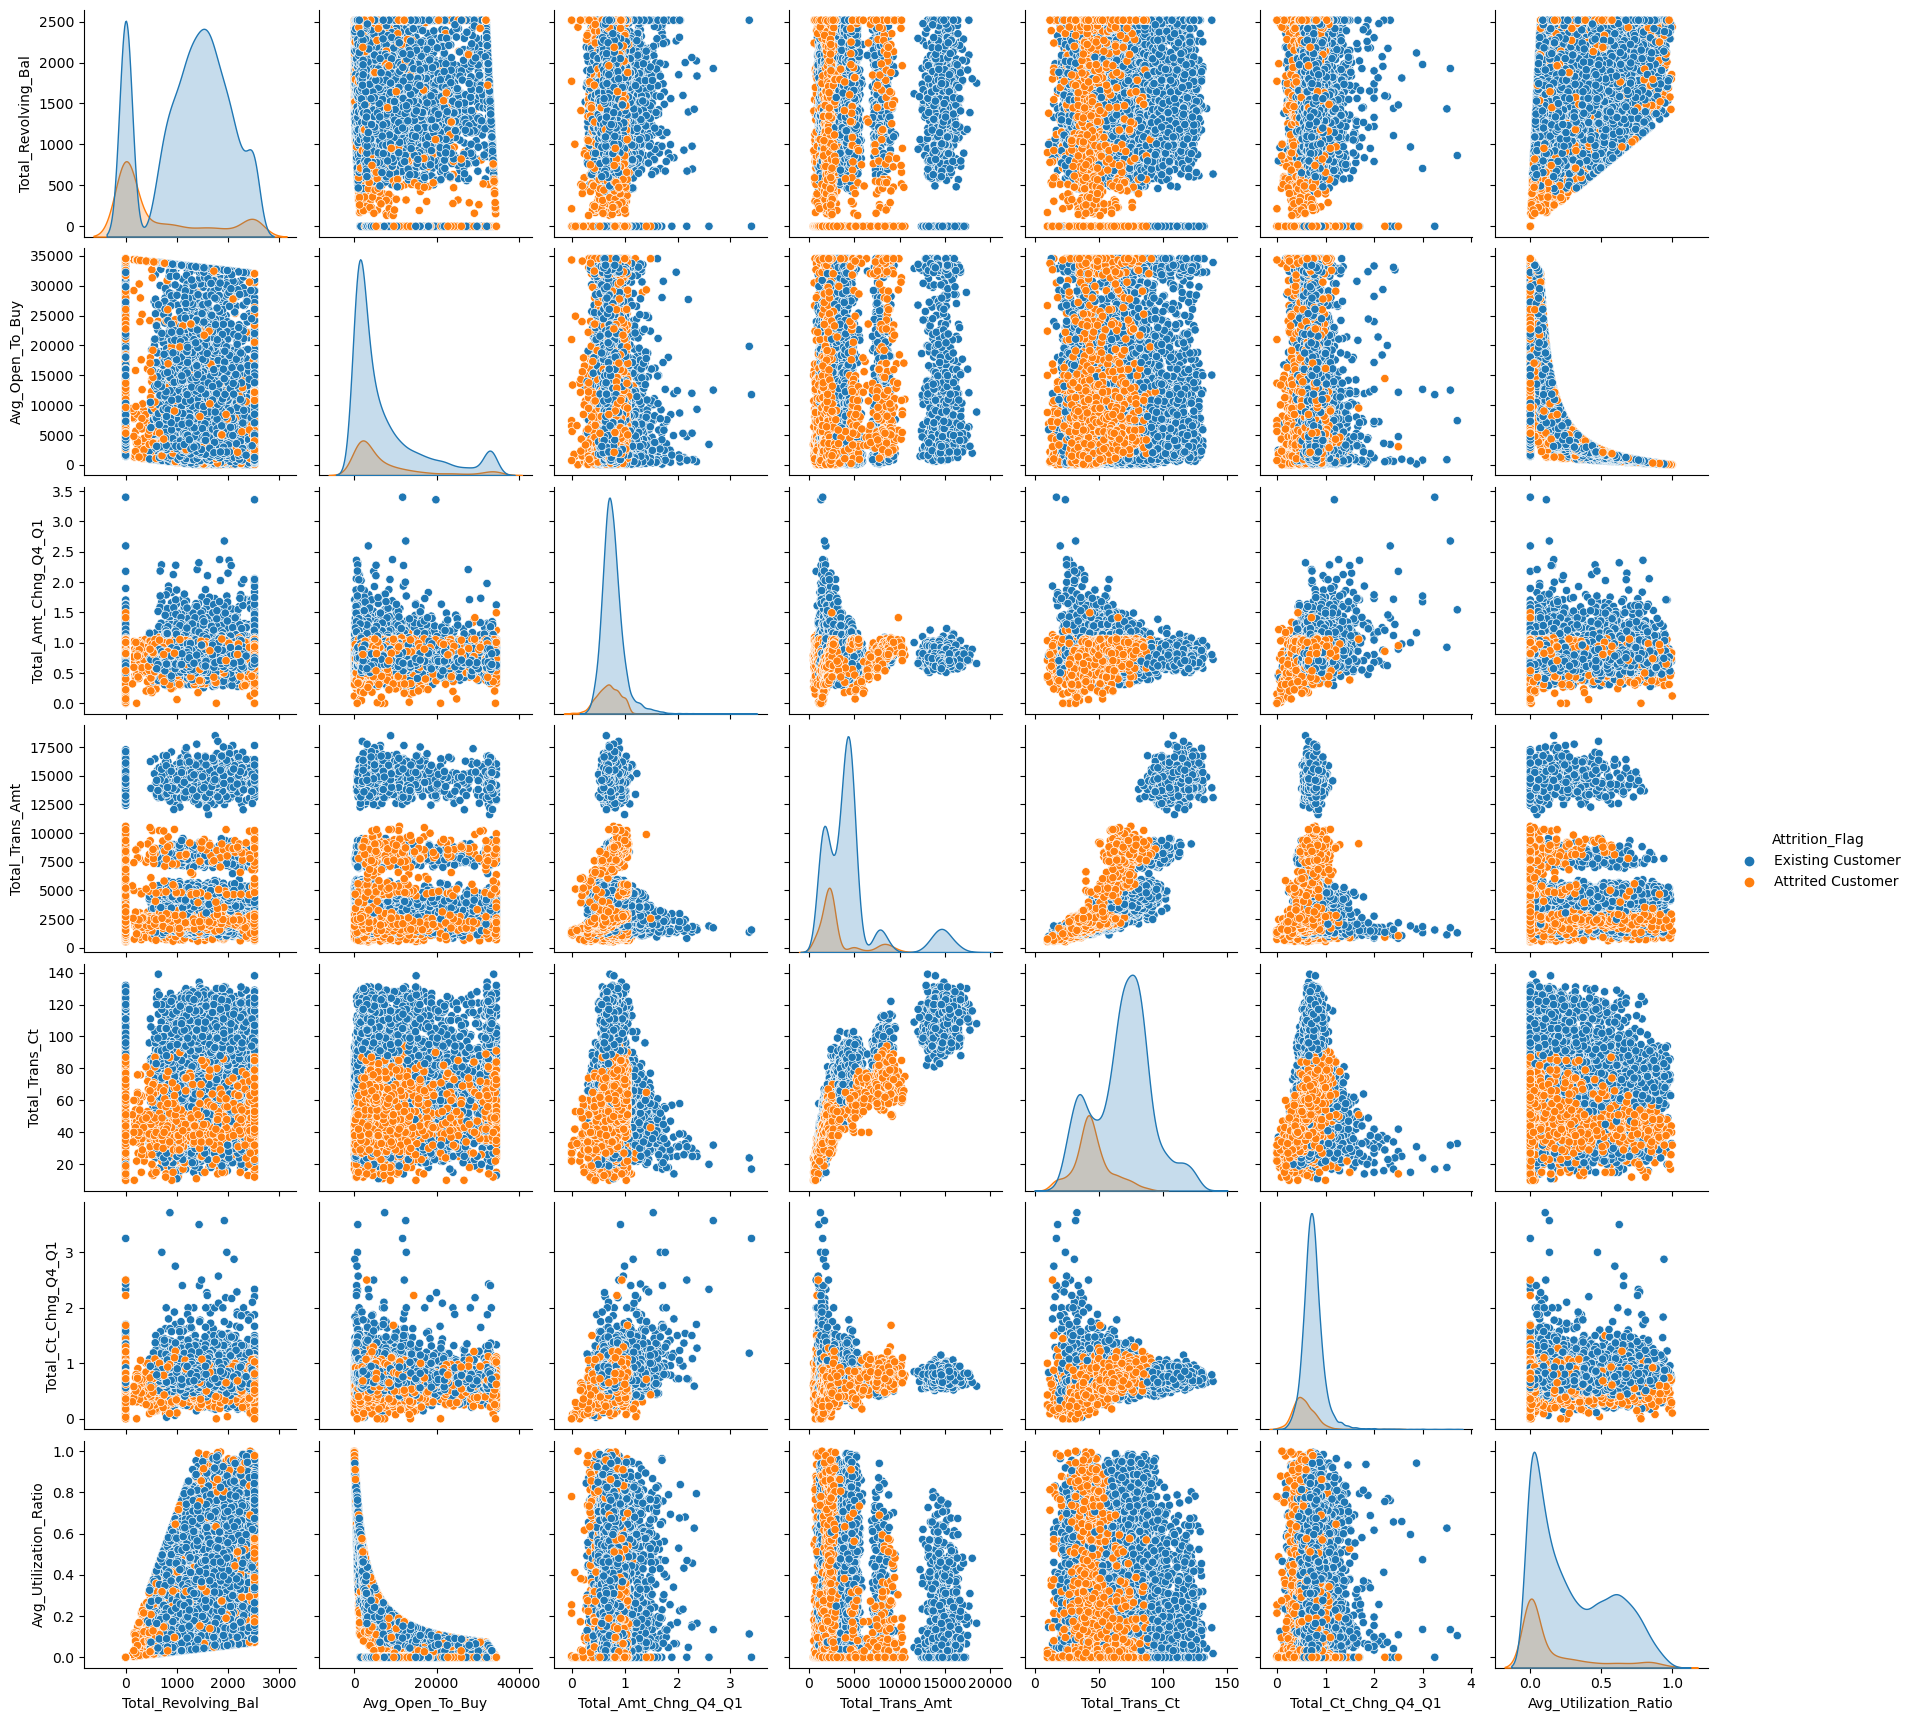

In [10]:
# Create pairplots for the last 7 numeric columns using 'y_col' as 'hue' 
sns.pairplot(data[numeric_columns[7:] + [y_col]], 
             hue = y_col)
# Show the plots
plt.plot()

- Total_Revolving_Bal, Total_Trans_Amt, Total_Trans_Ct, Total_Ct_Chng_Q4_Q1 , Avg_Utilization_Ratio: It's visible two different distribution for existing and attrited columns. Higher values show more frequency of existing customers; for lower values the relationship between existing and attrited columns is closer.

- Avg_Open_To_Buy, Total_Amt_Chng_Q4_Q1: The distribution for both type of customers is similar.

- Total_Ct_Chng_Q4_Q1, Total_Amt_Chng_Q4_Q1, Total_Trans_Amt, Total_Trans_Ct: The combination of each of these columns with the other shows a clear separation of existing and attrited columns.


In [11]:
# Data summary statistics
data.describe().T.round()

count    mean     std     min     25%     50%  \
Customer_Age              10127.0    46.0     8.0    26.0    41.0    46.0   
Dependent_count           10127.0     2.0     1.0     0.0     1.0     2.0   
Months_on_book            10127.0    36.0     8.0    13.0    31.0    36.0   
Total_Relationship_Count  10127.0     4.0     2.0     1.0     3.0     4.0   
Months_Inactive_12_mon    10127.0     2.0     1.0     0.0     2.0     2.0   
Contacts_Count_12_mon     10127.0     2.0     1.0     0.0     2.0     2.0   
Credit_Limit              10127.0  8632.0  9089.0  1438.0  2555.0  4549.0   
Total_Revolving_Bal       10127.0  1163.0   815.0     0.0   359.0  1276.0   
Avg_Open_To_Buy           10127.0  7469.0  9091.0     3.0  1324.0  3474.0   
Total_Amt_Chng_Q4_Q1      10127.0     1.0     0.0     0.0     1.0     1.0   
Total_Trans_Amt           10127.0  4404.0  3397.0   510.0  2156.0  3899.0   
Total_Trans_Ct            10127.0    65.0    23.0    10.0    45.0    67.0   
Total_Ct_Chng_Q4_Q1       10127.0     1.0     0.0     0.0     1.0     1.0   
Avg_Utilization_Ratio     10127.0     0.0     0.0     0.0     0.0     0.0   

                              75%      max  
Customer_Age                 52.0     73.0  
Dependent_count               3.0      5.0  
Months_on_book               40.0     56.0  
Total_Relationship_Count      5.0      6.0  
Months_Inactive_12_mon        3.0      6.0  
Contacts_Count_12_mon         3.0      6.0  
Credit_Limit              11068.0  34516.0  
Total_Revolving_Bal        1784.0   2517.0  
Avg_Open_To_Buy            9859.0  34516.0  
Total_Amt_Chng_Q4_Q1          1.0      3.0  
Total_Trans_Amt            4741.0  18484.0  
Total_Trans_Ct               81.0    139.0  
Total_Ct_Chng_Q4_Q1           1.0      4.0  
Avg_Utilization_Ratio         1.0      1.0

## Outliers

The outliers can affect the perfomance of some models as the logistic regression and the Support Vector Machine. So, they will be identified by Boxplots:

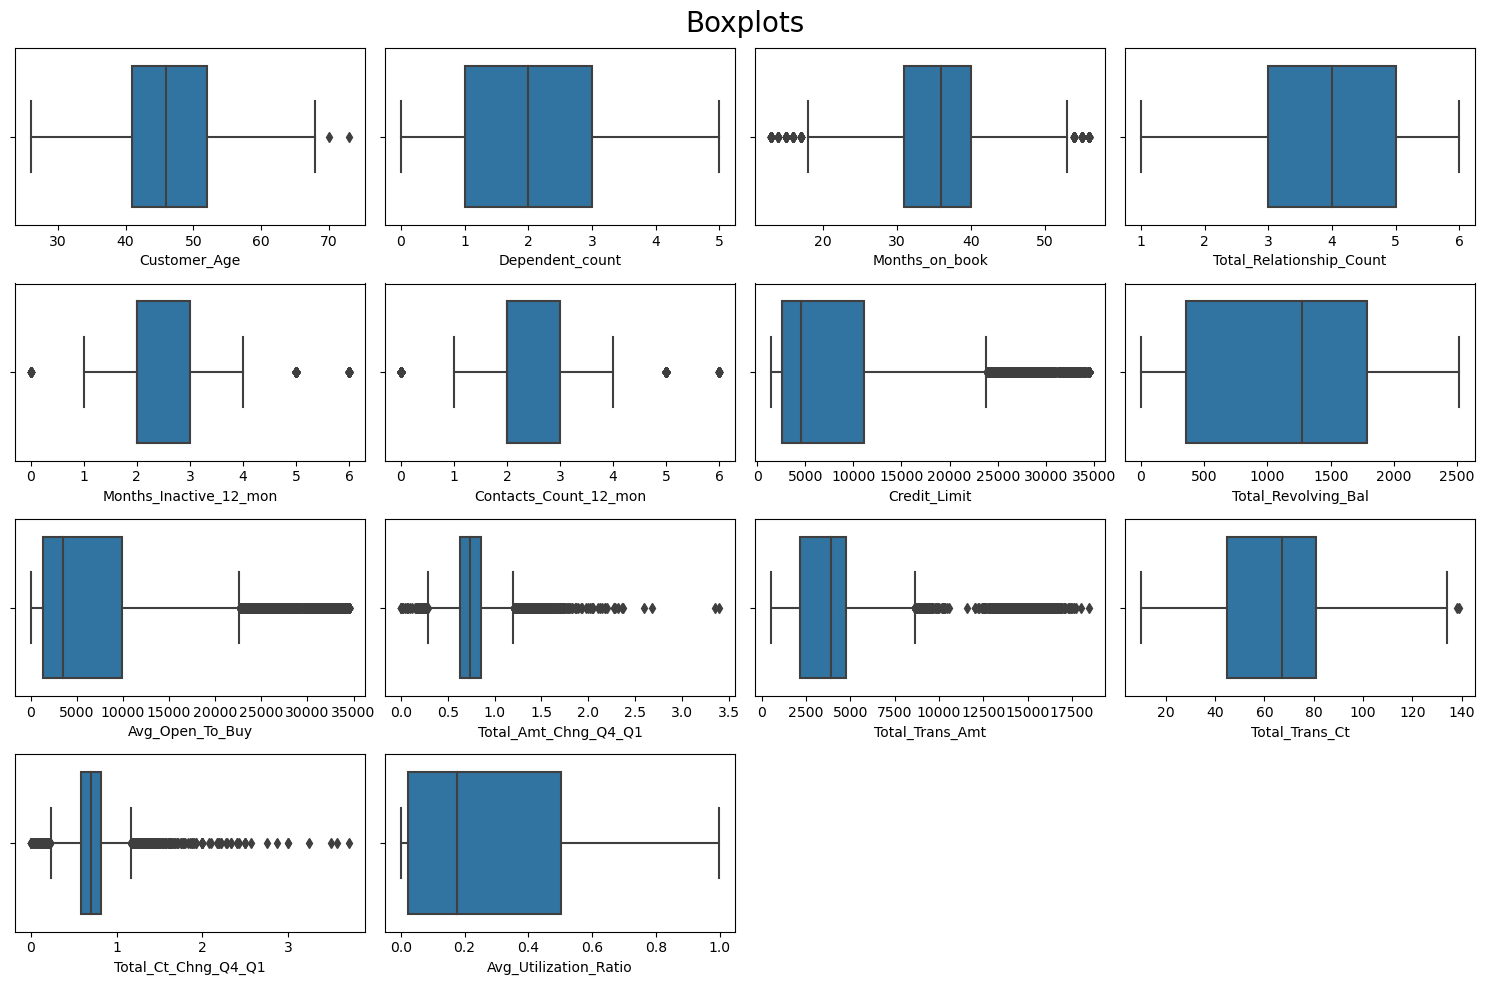

In [12]:
# Create 4 rows and 4 columns of subplots
fig, axes = plt.subplots(4, 4, 
                         figsize = (15, 10), 
                         sharey = True)
# Create the Suptitle
fig.suptitle('Boxplots',
            fontsize = 20)

for i, ax in enumerate(axes.flatten()):
    if i < len(numeric_columns):
        # Create the Boxplots for each numeric column
        sns.boxplot(x = numeric_columns[i],
                    data = data[numeric_columns + [y_col]],
                    ax = ax)
        # Set X label
        ax.set_xlabel(numeric_columns[i])
# Delete empy graphics
{fig.delaxes(axes[3, i]) for i in (2, 3)}
# Fit the space between the charts
plt.tight_layout()
# Show the plots
plt.show()

The dataset exhibits a notable presence of outliers across various columns. However, preserving these outliers within the DataFrame is essential given the relatively small sample size, as removing them might lead to further data loss. Additionally, it's important to mention that some of the models to be applied later in the analysis possess resilience to the influence of outliers, making their presence less concerning in this context

## Correlation

Columns highly correlated have also a negative performance in parametric models. So let's to graphic the correlation matrix to find correlated columns:

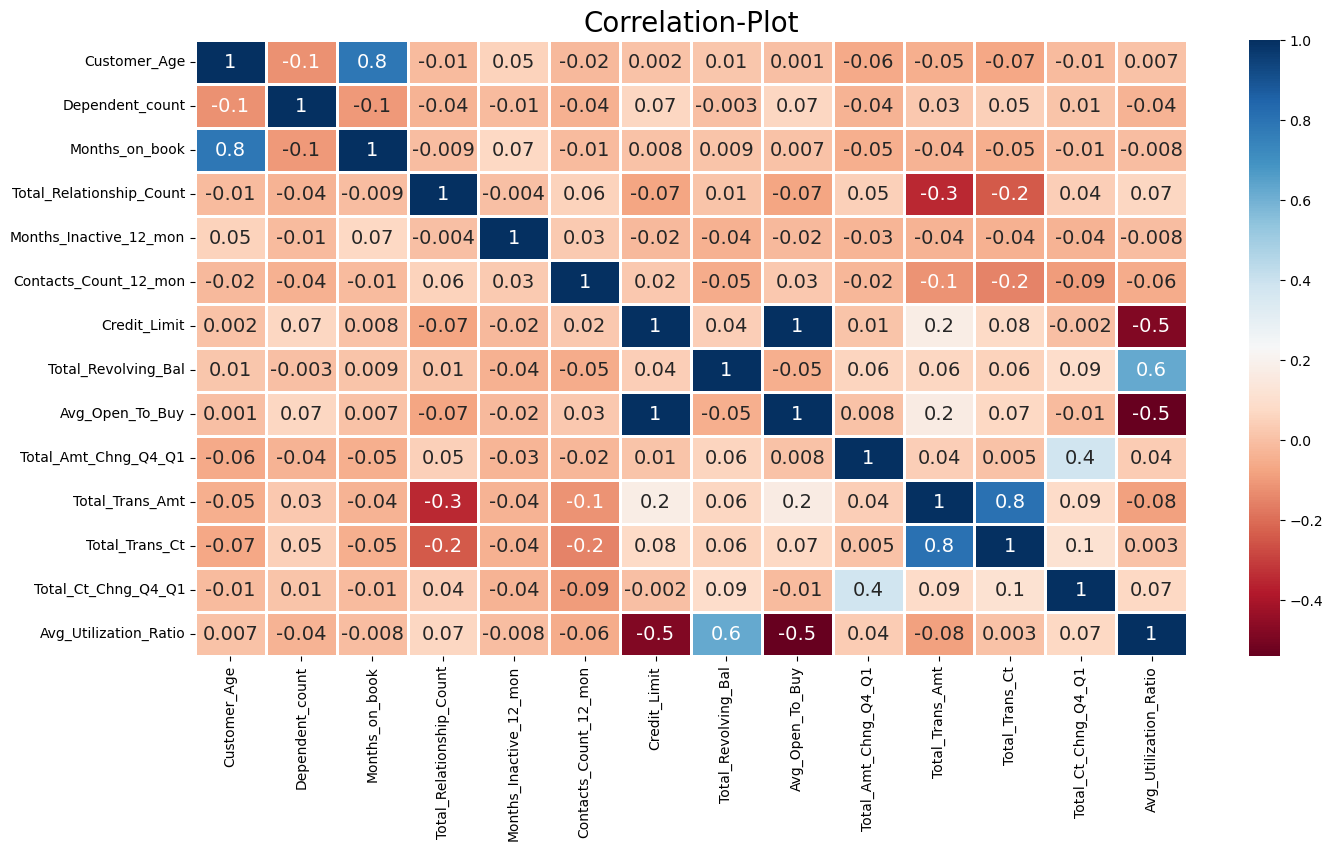

In [13]:
# Create correlation matrix
corr = data[numeric_columns].corr()
# Set the graphic size
plt.figure(figsize = (16, 8))
# Create the heatmap of the correlation matrix
sns.heatmap(data = corr,
            cmap = 'RdBu',
            fmt = '.0g',
            linewidths = 1,
            annot = True,
            annot_kws = {'size': 14})
# Set title
plt.title('Correlation-Plot', 
          fontsize = 20)
# Show the graphic
plt.show()


There is a perfect correlation between  'Credit_Limit' and 'Avg_Open_To_By' so one of them will be removed from the dataframe. The next code identify correlated columns and save them into a list:

In [14]:
# Create a list that includes correlated columns. They'll be removed from the dataframe
col_to_delete = list()

for col in corr.columns:
    if col not in col_to_delete:

        # Mask to get filter the lower triangle of the correlation matrix
        mask = np.tri(corr.shape[0], 
                      k = 1, 
                      dtype = bool)
        # Get columns with correlation above 85%
        correlated_col = corr.where(mask).stack()[col].abs().between(0.85, 0.999)
        # Get the column names
        correlated_col = correlated_col[lambda x: x == True].index
        # Add the correlated column to the list
        col_to_delete += list(correlated_col)

print("Correlated Columns:")
for col in col_to_delete:
        print(f"- {col}")

Correlated Columns:
- Credit_Limit


Credit Limit column is removed from the dataframe

In [15]:
# Remove correlated columns from the 'object_columns' and 'numeric_columns' lists 
for col in col_to_delete:
    if data[col].dtype == 'O':
        object_columns.remove(col)
    else:
        numeric_columns.remove(col)
# Delefe correlated column from the data
data.drop(col_to_delete, 
          axis = 1,
          inplace = True)

## Null Values

There are not null values in the dataframe:

In [16]:
# Null Value check
assert data.isna().sum().sum() == 0, 'There are missing values'

## Preprocessing

The `data_processing()` function is designed to perform data preprocessing tasks in order to prepare the dataset for modeling. These tasks include:

1. **Data Replacing:** Replacing 'unkown' values in categorical columns by the mode of the column

2. **Converting Object Columns into Dummy Variables:** For categorical columns, this function will convert them into a set of binary "dummy" variables.

4. **Creating Bins:** For numerical variables, creating bins or intervals to discretize the data, and calculating the churn proportion for each one.

5. **Scaling:** Standardizing numerical variables to ensure that they have similar scales.


Below of it, the pre_processing_inverse() that is the inverse of the pre_processing() function.


In [17]:
def pre_processing(df_: pd.DataFrame, 
                   object_columns: list,
                   numeric_columns: list,
                   y_col: str):
    
    """ Data preprocessing encompasses data replacement, bin creation,
        churn calculation, conversion of object columns into dummy variables,
        proportion calculation for numerical variables, and data scaling. 
        Returns X (features), y (label), the encoder and the scaler """
    # Make a copy of the df_
    df = df_.copy()
    # Convert y_col to dummy
    df[y_col] = np.where(df[y_col] == 'Existing Customer', 0, 1)

    for col in df.columns.drop(y_col):
        if df[col].dtype == 'O':
            # Replace 'Unknown' for the column Mode 
            mode = df[col].mode()[0]
            df[col] = df[col].replace({'Unknown': mode}) if 'Unknown' in df[col].unique() else df[col]
            # Add new column grouped
            group = df.groupby(col)[y_col].mean()
            df[f'{col}_churn_prop'] = df[col].map(group)
            
    
        else:
            # Create 8 bins for each numeric column
            bins = pd.cut(df[col], bins = 8)
            # Add the bins as a new column
            df[f'{col}_bins'] = bins
            # Calculate of churn proportion for each bin
            group = df.groupby(f'{col}_bins')[y_col].mean()
            # Map the churn proportion by creating a new column into the dataframe
            df[f'{col}_churn_prop'] = df[col].map(group)
            # Delete the bin column from the dataframe
            df.drop(f'{col}_bins', 
                    axis = 1,
                    inplace = True)
            
    # Convert category columns into dummies
    encoder = OneHotEncoder()
    encoder.fit(df[object_columns])
    
    # Set dummy as data frame keeping the original index
    dummies = pd.DataFrame(encoder.transform(df[object_columns]).toarray(), 
                           columns = encoder.get_feature_names_out(),
                           index = df.index)

    # Drop category columns
    df.drop(object_columns,
            axis = 1,
            inplace = True)
    # Initialize the Scaler
    scaler = MinMaxScaler()
    # Scale numeric columns
    df_scaled = pd.DataFrame(scaler.fit_transform(df.drop(y_col, axis = 1)), 
                             index = df.index,
                             columns = df.columns.drop(y_col))

    # Join the dummies to the dataframe
    df = df_scaled.join([dummies, df[y_col]])
    # Get Features
    X = df.drop(y_col,
                axis = 1)
    # Get predicted col
    y = df[y_col]

    return X, y, encoder, scaler


def pre_processing_inverse(df: pd.DataFrame, 
                           object_columns: list, 
                           numeric_columns: list,
                           scaler, 
                           encoder 
                           ) -> pd.DataFrame:
    """ Returns the inverse of the pre_processing() function in order to get
        the real X dataframe given the X_pre_processed one """
    # Mask to get the dummy column names 
    mask = np.repeat(False, len(df.columns))
    for col in object_columns:
        mask = mask | (df.columns.str.startswith(col) & ~df.columns.str.endswith('prop'))
    # Apply the encoder inverse to the dummies in the df
    object_df = pd.DataFrame(encoder.inverse_transform(df[df.columns[mask]].values),
                                     columns = object_columns,
                                     index = df.index)
    # Get numeric columns to unscale
    numeric_columns_to_convert = df.columns[np.isin(df.columns,
                                                    scaler.get_feature_names_out())]
    # Apply the scaler invers to the numeric columns in the df
    numeric_df = pd.DataFrame(scaler.inverse_transform(df[numeric_columns_to_convert]),
                              columns = numeric_columns_to_convert,
                              index = df.index)
    # Join object_df and numeric_df
    X = numeric_df[numeric_columns].join(object_df)
    
    return X


In [18]:
# Data Preprocess splitting the 'X' features and the 'y' label from 'data'
X, y, encoder, scaler = pre_processing(data.copy(), 
                                    object_columns,
                                    numeric_columns,
                                    y_col)

## Train/Test split

The train_test_splitter() function divides the dataset into training and testing sets while preserving the column distribution. It first combines the features and labels into a single DataFrame. Then, it determines the training and testing indices, taking into account the category distribution in categorical columns and discretizing numerical columns into 8 bins. In this way, both training and testing dataframe will contain the same distribution for each column.


In [19]:
def train_test_splitter(X: pd.DataFrame,
                        y: pd.Series, 
                        p: tuple = (0.7, 0.2, 0.1)) -> (pd.DataFrame, # X_train
                                                        pd.DataFrame, # X_val
                                                        pd.DataFrame, # X_test
                                                        pd.Series,    # y_train
                                                        pd.Series,    # y_val
                                                        pd.Series):    # y_test
    """ Split into train, val and test the orifinal dataframe, keeping the distribution
        of the columns in both of them """
                                                        
    assert round(sum(p)) == 1, 'Proportions must sum 1'
    # Join Features and Labels
    df = X.join(y)
    # train_idx contains the training indexes 
    train_idx = set()
    
    for col in df.columns:
        if df[col].dtype == 'O':
            # For object columns calculate the distrution of the categories
            col_distribution = (df[col].value_counts() * p[0]).round()
        else:
            # Discretize numeric columns in 8 bins 
            bins = 8
            labels = [f"label_{i}" for i in range(bins)]
            discretized_col = pd.cut(df[col],
                                     bins = bins,
                                     labels = labels)
            # Calculate the distrution of the new categories
            col_distribution = (discretized_col.value_counts() * p[0]).round()
        
        for cat, count in col_distribution.items():
            # Obtain the indices of the DataFrame for the category
            cat_index = df.index[df[col] == cat] if df[col].dtype == 'O' else df.index[discretized_col == cat]
            # Get the current number of indices in the train_idx
            current = np.isin(cat_index, list(train_idx)).sum()
            # 'number_to_add' is the number of indices to add in order to keep the same distribution
            # in both training and testing
            number_to_add = int(max(0, count - current))
            
            if number_to_add > 0:
                # Get a random 'number_to_add' size of indices 
                np.random.seed(43)
                index = np.random.choice(cat_index, 
                                         size = number_to_add, 
                                         replace = False,
                                        )
                # Add indices to train_idx
                train_idx.update(index)
    # Get Validation idx
    val_idx = np.random.choice(df.index.difference(train_idx), 
                             size = int(len(df) * p[1]), 
                             replace = False,
                             )

    # Get testing idx
    test_idx = df.index.difference(list(train_idx) + list(val_idx))
    # Convert 'train_idx' and 'test_idx' as list
    train_idx, val_idx , test_idx = list(train_idx), list(val_idx), list(test_idx)
    # filter X by 'train_idx' list to get 'X_train' and 'y_train' 
    X_train = X.loc[train_idx]
    X_train.index = train_idx
    y_train = y.loc[train_idx]
    y_train.index = train_idx
    # filter X by 'val_idx' list to get 'X_test' and 'y_test' 
    X_val = X.loc[val_idx]
    X_val.index = val_idx
    y_val = y.loc[val_idx]
    y_val.index = val_idx
    # filter X by 'test_idx' list to get 'X_test' and 'y_test' 
    X_test = X.loc[test_idx]
    X_test.index = test_idx
    y_test = y.loc[test_idx]
    y_test.index = test_idx
    
    return X_train, X_test, X_val, y_train, y_val, y_test

# Splitting X and y into training and testin dataframes
X_train, X_test, X_val, y_train, y_val, y_test = train_test_splitter(X, y)

## Model Evaluation

The models will be evaluated by their F1. The reason behind this choice lies in the fact that the F1 Score considers both precision and recall, making it more robust in the face of class imbalances. Since correctly identifying customers about to churn is crucial in a churn problem, the F1 Score provides a more balanced assessment of the model's performance.

To select the best combination of parameters, we will create a function called model_eval(). This function will generate a plot displaying the F1 Score for both the training and validation datasets as a function of different parameter combinations. Additionally, the function will provide model results for both datasets for each parameter combination.


In [20]:
def model_eval(model,
               params: dict,
               X: list,
               y: list,
               ) -> (pd.DataFrame, plt.figure):
    """ Returns two objects: The first one is a DataFrame with the results of the CV,
        and the second one it's a graphic of the Bias-Variance Trade Off """
    # Get param combinations
    grid_params = list(itertools.product(*params.values()))
    # Get training and Validation dataframes
    X_train, X_val = X[0], X[1]
    y_train, y_val = y[0], y[1]
    # Set f1-score 
    f1_scorer = make_scorer(f1_score)
    # List to save scores and params
    train_scores = []
    val_scores = []
    param_combs = []

    for param_comb in grid_params:
        # Make dictionary with params names and values
        param = dict(zip(params.keys(), param_comb))
        # Set params to the model
        model.set_params(**param)
        # Train model with 4 cross-validations
        cv_scores = cross_val_score(estimator = model,
                                       X = X_train,
                                       y = y_train,
                                       cv = 5,
                                       n_jobs = -1)
        # Get the mean train score
        train_score = cv_scores.mean()
        # Save train score to the list
        train_scores.append(train_score)
        
        # Fit model
        model.fit(X_train, y_train)
        # predict labels for the validation dataframe
        y_val_pred = model.predict(X_val)
        # Get f1 score for the validation dataframe
        val_score = f1_score(y_val, y_val_pred)
        # Save validation score to the list
        val_scores.append(val_score)
        # Save the parameter combination to the list
        param_combs.append(param)
    # Save results as a dataframe
    cv_results = pd.DataFrame({'params': param_combs,
                                   'train_score': train_scores,
                                   'val_score': val_scores}).sort_values(by = 'train_score',
                                                                        ascending = True)
        
    # Graphic size
    plt.figure(figsize = (16, 8))
    # Seaborn style 
    sns.set()
    # Plot the Val F1
    plt.plot(np.arange(len(cv_results)),
             cv_results['val_score'],
             label = 'Validation',
             marker = 'x')

    # Plot the Train F1
    plt.plot(np.arange(len(cv_results)),
             cv_results['train_score'],
             label = 'Training',
             marker = 'x')
    # Labels
    model_name = str(model).split('(')[0]
    plt.title(f'{model_name} Model: Bias - Variance Trade-Off',
              fontsize = 20)
    plt.xlabel('Hyperparameter index',
               fontsize = 14)
    plt.ylabel('F1-Score',
               fontsize = 14)
    plt.legend(fontsize = 16)

    return cv_results, plt

## Models

The models used in this project includes the logistic regression, random forest, XGBoost, and support vector machine (SVM). To determine which of these models is the most suitable, it will be performed a hyperparameter tuning process using a grid. This process will be guided by the results obtained with the previously mentioned model_eval() function.

The model_eval() function will provide us with a performance comparison across different models based on their hyperparameter combinations. We can then identify which of these models shows the most promise in terms of its ability to predict churn. The goal is to select the model that offers the best trade-off between precision and recall, which is crucial in a churn prediction problem.


### Logistic Regression

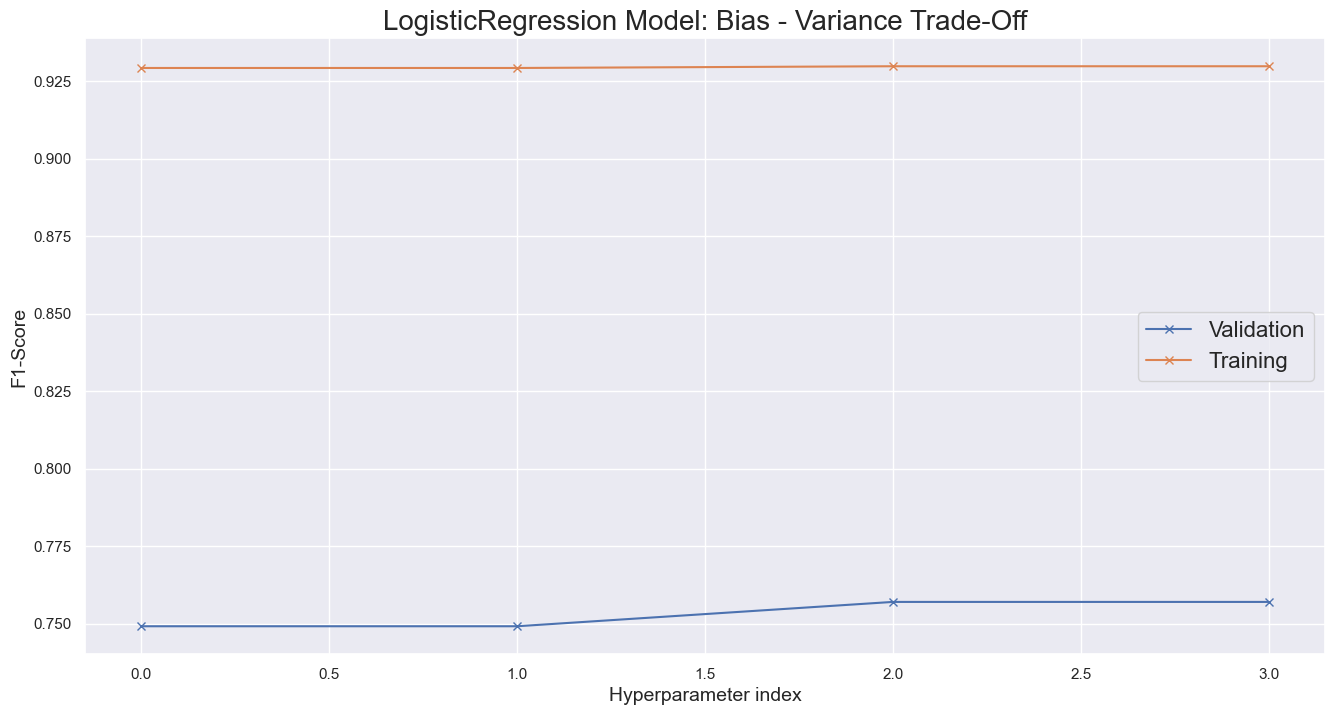

In [21]:
# Grid of hyperparameters for logistic Model
logistic_param_grid = {
    'max_iter': [250, 500],
    'fit_intercept': [True, False]
}
# Initialize logistic Model
logistic_model = LogisticRegression(random_state = 43)
# Grid Search with 5-fold Cross-Validation for the logistic Model
logistic_results, _ = model_eval(logistic_model,
                                 logistic_param_grid,
                                 [X_train, X_val],
                                 [y_train, y_val])

#### Logistic Regression - Best Model

The F1 Score for both training and validation data is highest for the logistic regression model with the parameters found at index 2. Therefore, this will be the best hyperparameter combination for this model.

In [22]:
# Select the best combination of parameters for the logistic regression model
logistic_best_params = logistic_results['params'][2]
# Best Logistic Model
logistic_best_model = LogisticRegression(random_state = 43,
                                        **logistic_best_params)
# Fit the Best Logistic Model
logistic_best_model.fit(X_train, 
                        y_train)

print(f"Logistic Regression Best params: {logistic_best_params}")

Logistic Regression Best params: {'max_iter': 500, 'fit_intercept': True}


### Random Forest

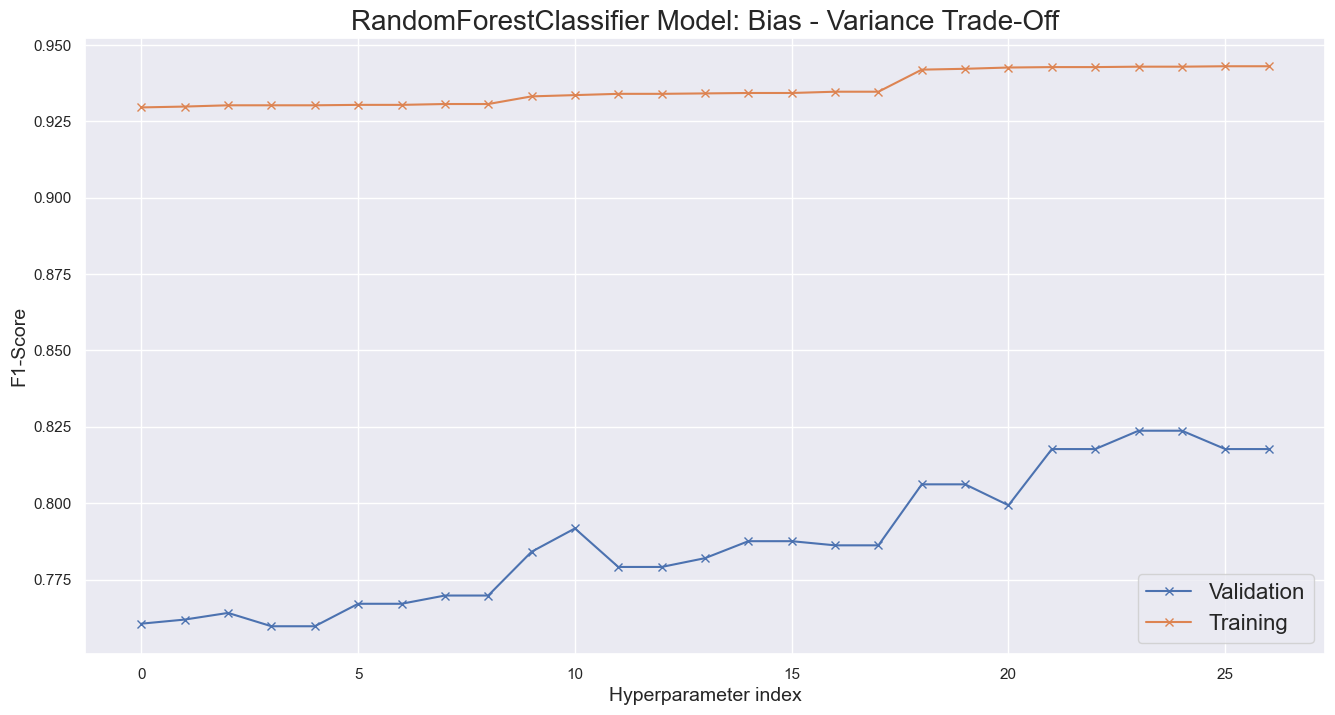

In [26]:
# Grid of hyperparameters for Random Forest Model
rf_param_grid = {
    'n_estimators': [250, 500, 1000],
    'max_depth' : [10, 25, 30],
    'min_samples_leaf': [10, 20, 25]
}
# Initialize Random Forest Model
rf_model = RandomForestClassifier(random_state = 43)
# Grid Search with 5-fold Cross-Validation for the Random Forest Model
rf_results, _ = model_eval(rf_model,
                           rf_param_grid,
                           [X_train, X_val],
                           [y_train, y_val])

#### Random Forest - Best Model

For the random forest model, we can observe a gap between the F1 Score results for training and validation data, which is higher as the model becomes more complex, until some point where the score remains equal for the training set and it goes down for the validation one. 

So, the best combination of hyperparameters that yield the best results are located at the last index 23

In [27]:
# Select the best combination of parameters for the Random Forest model
rf_best_params = rf_results['params'][23]
# Best Random Forest Model
rf_best_model = RandomForestClassifier(random_state = 43,
                                       **rf_best_params)
# Fit the Best Random Forest Model
rf_best_model.fit(X_train, 
                  y_train)

print(f"Random Forest Best params: {rf_best_params}")

Random Forest Best params: {'n_estimators': 1000, 'max_depth': 25, 'min_samples_leaf': 25}


### XGBoost

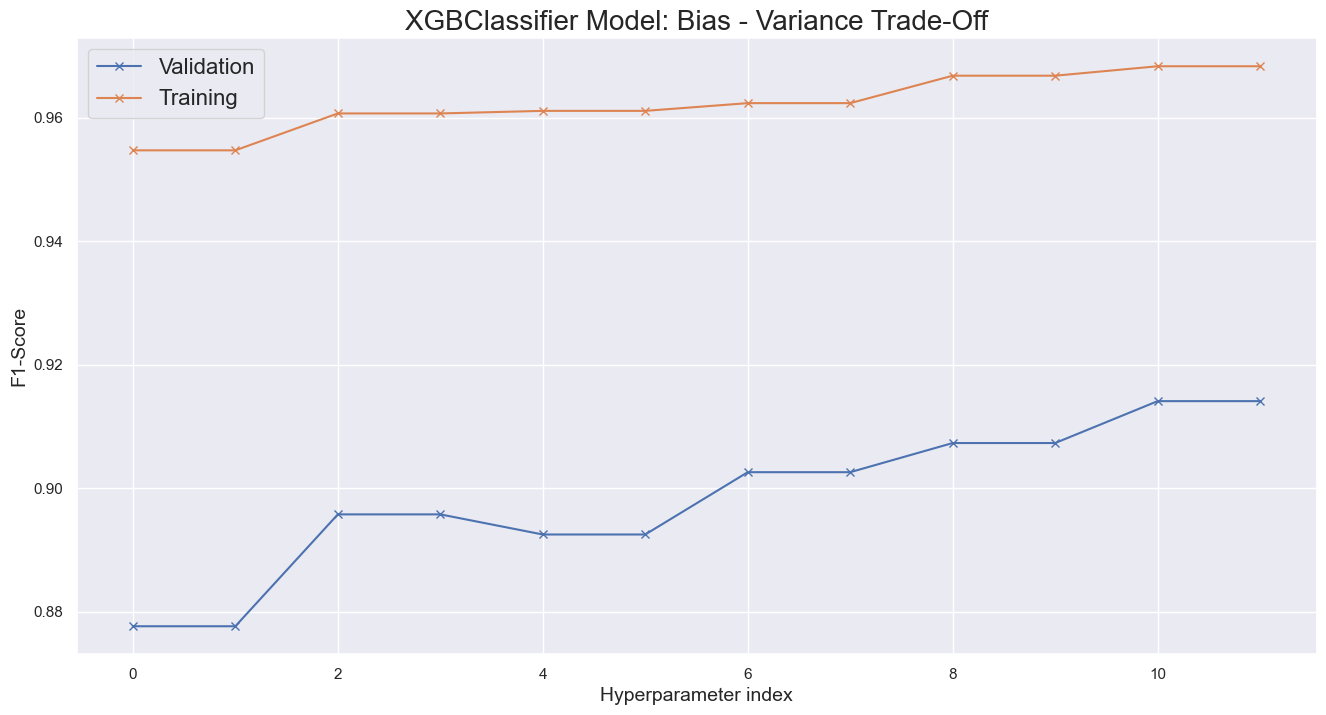

In [28]:
# Initialize XGBoost Model
xgb_model = xgb.XGBClassifier(random_state = 42)
# Grid of hyperparameters for XGB Model
xgb_param_grid = {
    'n_estimators': [100, 250, 350],
    'learning_rate': [0.01, 0.03],
    'max_depth': [25, 35],  
    'subsample': [0.8],  
    'colsample_bytree': [0.8]
}
# Grid Search with 5-fold Cross-Validation for the XGB Model
xgb_results, _ = model_eval(xgb_model,
                            xgb_param_grid,
                            [X_train, X_val],
                            [y_train, y_val])

#### XGBoost - Best Model

For the XGBoost the results for validation data increase in training and validation dataframes until the hyperparameters located in the index 11.

In [29]:
# Select the best combination of parameters for the XGBoost model
xgb_best_params = xgb_results['params'][11]
# Best XGBoost Model
xgb_best_model = xgb.XGBClassifier(random_state = 43,
                                   **xgb_best_params)
# Fit the Best XGBoost Model
xgb_best_model.fit(X_train, 
                   y_train)

print(f"XGBoost Best params: {xgb_best_params}")

XGBoost Best params: {'n_estimators': 350, 'learning_rate': 0.03, 'max_depth': 35, 'subsample': 0.8, 'colsample_bytree': 0.8}


### Support Vectors Machine 

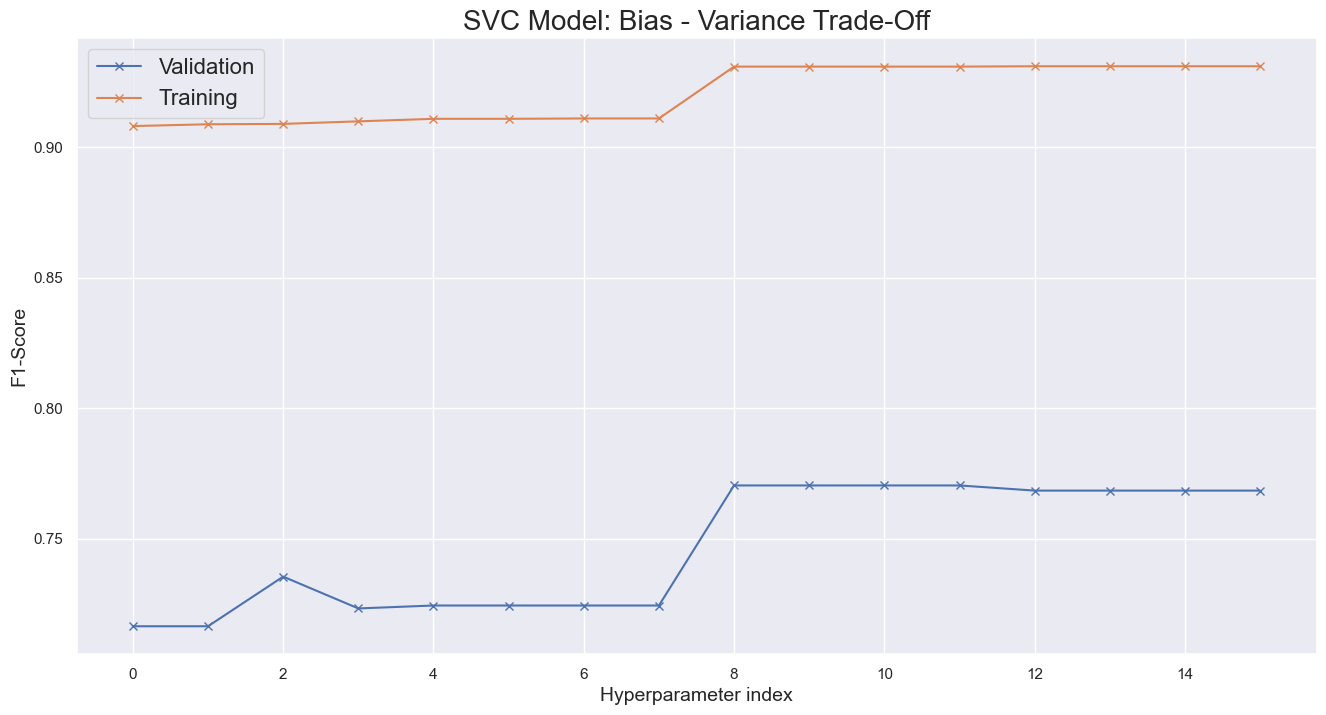

In [30]:
    # Grid of hyperparameters for SVC Model
    svm_model = SVC(random_state = 42)
    # Initialize SVC Model
    svm_param_grid = {
        'C': [500, 1000],
        'kernel':  ['linear', 'poly'],
        'degree': [2, 3],
        'gamma': [0.7, 0.9]
    }
    # Grid Search with 5-fold Cross-Validation for the SVC Model
svm_results, _ = model_eval(svm_model,
                            svm_param_grid,
                            [X_train, X_val],
                            [y_train, y_val])

In [41]:
list(svm_results['params'])

[{'C': 1000, 'kernel': 'poly', 'degree': 2, 'gamma': 0.9},
 {'C': 1000, 'kernel': 'poly', 'degree': 2, 'gamma': 0.7},
 {'C': 500, 'kernel': 'poly', 'degree': 2, 'gamma': 0.7},
 {'C': 500, 'kernel': 'poly', 'degree': 2, 'gamma': 0.9},
 {'C': 500, 'kernel': 'poly', 'degree': 3, 'gamma': 0.7},
 {'C': 1000, 'kernel': 'poly', 'degree': 3, 'gamma': 0.7},
 {'C': 500, 'kernel': 'poly', 'degree': 3, 'gamma': 0.9},
 {'C': 1000, 'kernel': 'poly', 'degree': 3, 'gamma': 0.9},
 {'C': 1000, 'kernel': 'linear', 'degree': 2, 'gamma': 0.7},
 {'C': 1000, 'kernel': 'linear', 'degree': 2, 'gamma': 0.9},
 {'C': 1000, 'kernel': 'linear', 'degree': 3, 'gamma': 0.7},
 {'C': 1000, 'kernel': 'linear', 'degree': 3, 'gamma': 0.9},
 {'C': 500, 'kernel': 'linear', 'degree': 2, 'gamma': 0.7},
 {'C': 500, 'kernel': 'linear', 'degree': 2, 'gamma': 0.9},
 {'C': 500, 'kernel': 'linear', 'degree': 3, 'gamma': 0.7},
 {'C': 500, 'kernel': 'linear', 'degree': 3, 'gamma': 0.9}]

#### Support Vectors Machine - Best Model

The SVM model is generating a resonable F1-score for both the training set but a the predictions are weak for the validation one, so the model is overfitting the training samples. There is a significant improvement for the hyperparameters in the index 8, so those ones will be selected as the best hyperparameters for the SVM model.

In [31]:
# Select the best combination of parameters for the Support Vectors Machine model
svm_best_params = svm_results['params'][8]
# Best Support Vectors Machine Model
svm_best_model = SVC(random_state = 43,
                     **svm_best_params,
                     probability = True)
# Fit the Best Support Vectors Machine Model
svm_best_model.fit(X_train, 
                   y_train)

print(f"SVM Best params: {svm_best_params}")

SVM Best params: {'C': 1000, 'kernel': 'linear', 'degree': 2, 'gamma': 0.7}


## Result Evaluation 

To compare the results of the 4 models tuned using cross-validation and grid search, we will create a function called results_eval(). This function will generate a ROC curve for the testing data, providing both the F1 Score and the AUC (Area Under the Curve) as evaluation metrics. This comprehensive analysis will allow us to assess and compare the models' performance in terms of their classification accuracy and discrimination ability

In [32]:
def results_eval(models: list, 
                 X_test: pd.DataFrame,
                 y_test: pd.Series) -> plt.figure:
    """ Return a plot of the Roc-Curve for all the models, including the
        AUC and F1 metrics """
    # Create a common figsize for all subplots
    fig, ax = plt.subplots(2, 2,
                           figsize = (16, 8), 
                           sharey = True)
    # Create the Suptitle
    fig.suptitle('Model Results', 
                 fontsize = 20)

    for i, model in enumerate(models):
        # Predict probabilities on the test set
        y_prob = model.predict_proba(X_test)[:, 1]
        # Calculate ROC curve
        fpr, tpr, thresholds = roc_curve(y_test, y_prob)
        # Calculate AUC (Area Under the Curve)
        auc = roc_auc_score(y_test, y_prob)
        # Calculate F1 Score
        f1 = f1_score(y_test, y_prob.round(0))
        # Set Color
        colors = sns.color_palette('pastel')
        # Get subplot idx
        idx = (i % 2, i // 2)
        # Plot the ROC curve
        ax[idx].plot(fpr,
                     tpr,
                     color = colors[0],
                     label = 'ROC')
        ax[idx].plot([0, 1], [0, 1],
                     color = colors[1], 
                     linestyle = '--')
        # Annotate the AUC and the f1 score
        ax[idx].annotate(f"AUC: {round(auc * 100, 1)}%", (0.15, 0.5))
        ax[idx].annotate(f"F1-Score: {round(f1 * 100, 1)}%", (0.15, 0.4))
        # Labels
        ax[idx].set_xlabel('False Positive Rate')
        ax[idx].set_ylabel('True Positive Rate')
        ax[idx].set_title(f"{str(model).split('(')[0]}")
        ax[idx].legend()

    # Fit the space between the charts
    plt.tight_layout()
    return plt.show()


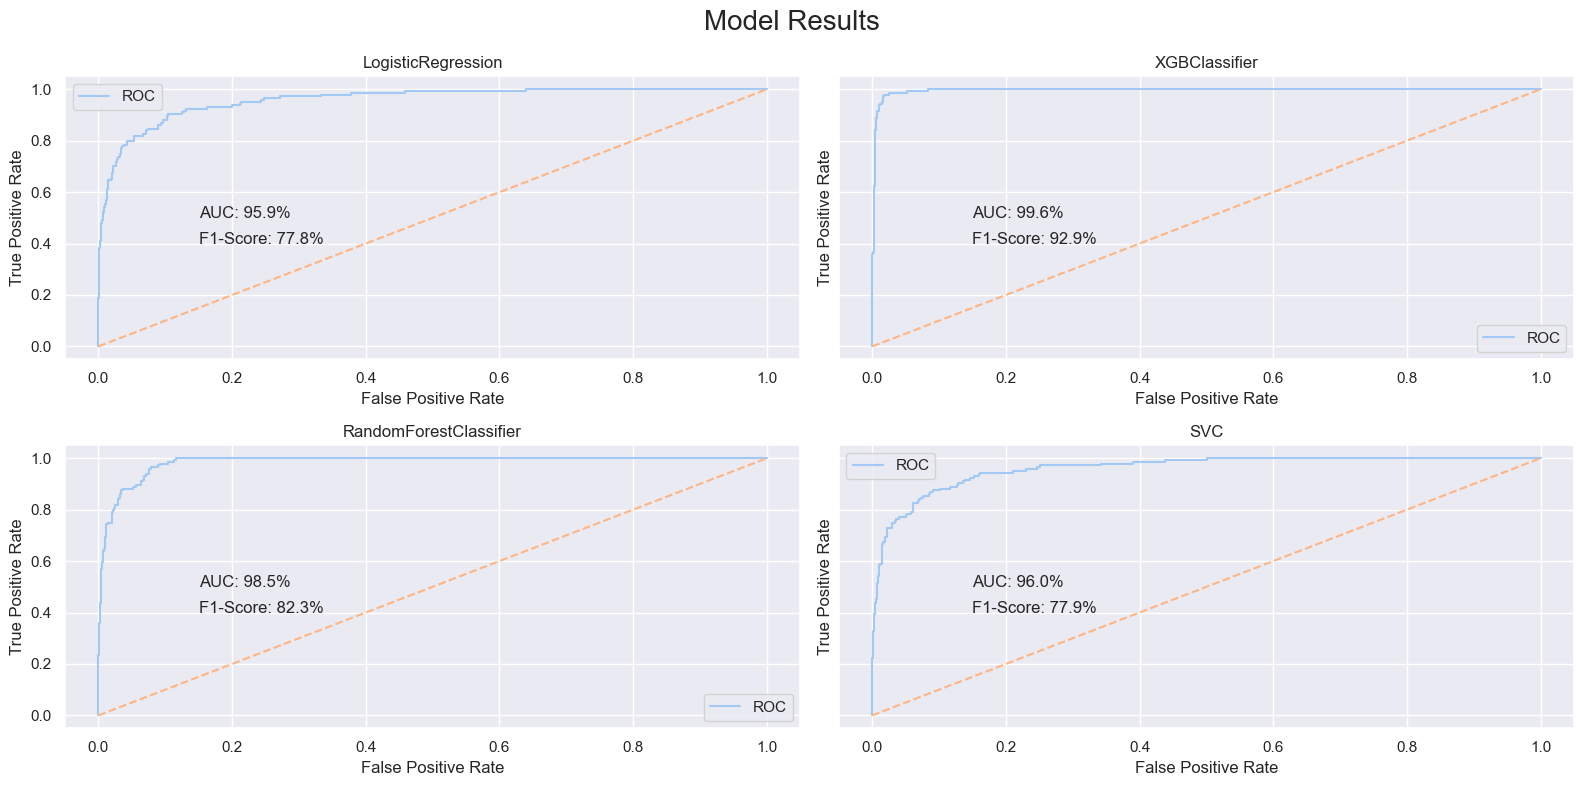

In [33]:
# List of the fitted models
models = [logistic_best_model, rf_best_model, xgb_best_model, svm_best_model]
# Testing: results for the models 
results_eval(models,
             X_test,
             y_test)

The effectiveness of the XGBoost model is clearly evident in the previous graph, displaying an AUC of 99.6% and an F1 score of 92.9%. These metrics signify a significantly superior performance compared to the other models.

An AUC of 99.6% indicates that the model's ability to discriminate between positive and negative cases is exceptionally high. 

Additionally, an F1 score of 92.9% represents a robust balance between precision and recall, which is essential in scenarios where achieving high accuracy while avoiding false positives and false negatives is crucial. This high F1 score indicates the model's excellence in classifying positive cases while minimizing both types of errors.

### Confusion Matrix

A confusion matrix will be generated to evaluate the predictions made by the XGBoost model. 

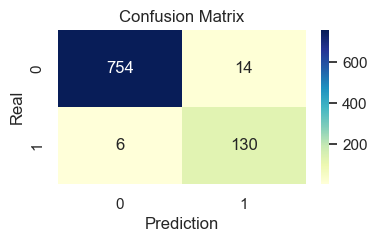

In [34]:
# Predictions for X_test by xgBoost model
pred_test = xgb_best_model.predict(X_test)
# Confusion Matrix between the real values and the predictions
confusion_matrix_ = confusion_matrix(pred_test, 
                                     y_test)
# Set the graphic size
plt.figure(figsize = (4, 2))
# Plot the confusion matrix
sns.heatmap(confusion_matrix_,
            annot = True,
             fmt='.4g',
            cmap = "YlGnBu")
# Graphic labels
plt.title("Confusion Matrix")
plt.xlabel('Prediction')
plt.ylabel('Real')
plt.show()

The model correctly predicted 130 instances of churn. This indicates that the model's ability to identify customers who are likely to churn is quite effective, as reflected by the high number of true positive predictions. 

Additionally, the low counts of both false positives (14 misclassifying non-churn customers as churners) and false negatives (6 failing to identify actual churners) suggest that the model's performance in minimizing both types of errors is commendable.

## Best Features

Let's to explore the best features in the XGBoost model to identify their importance in the churn prediction.

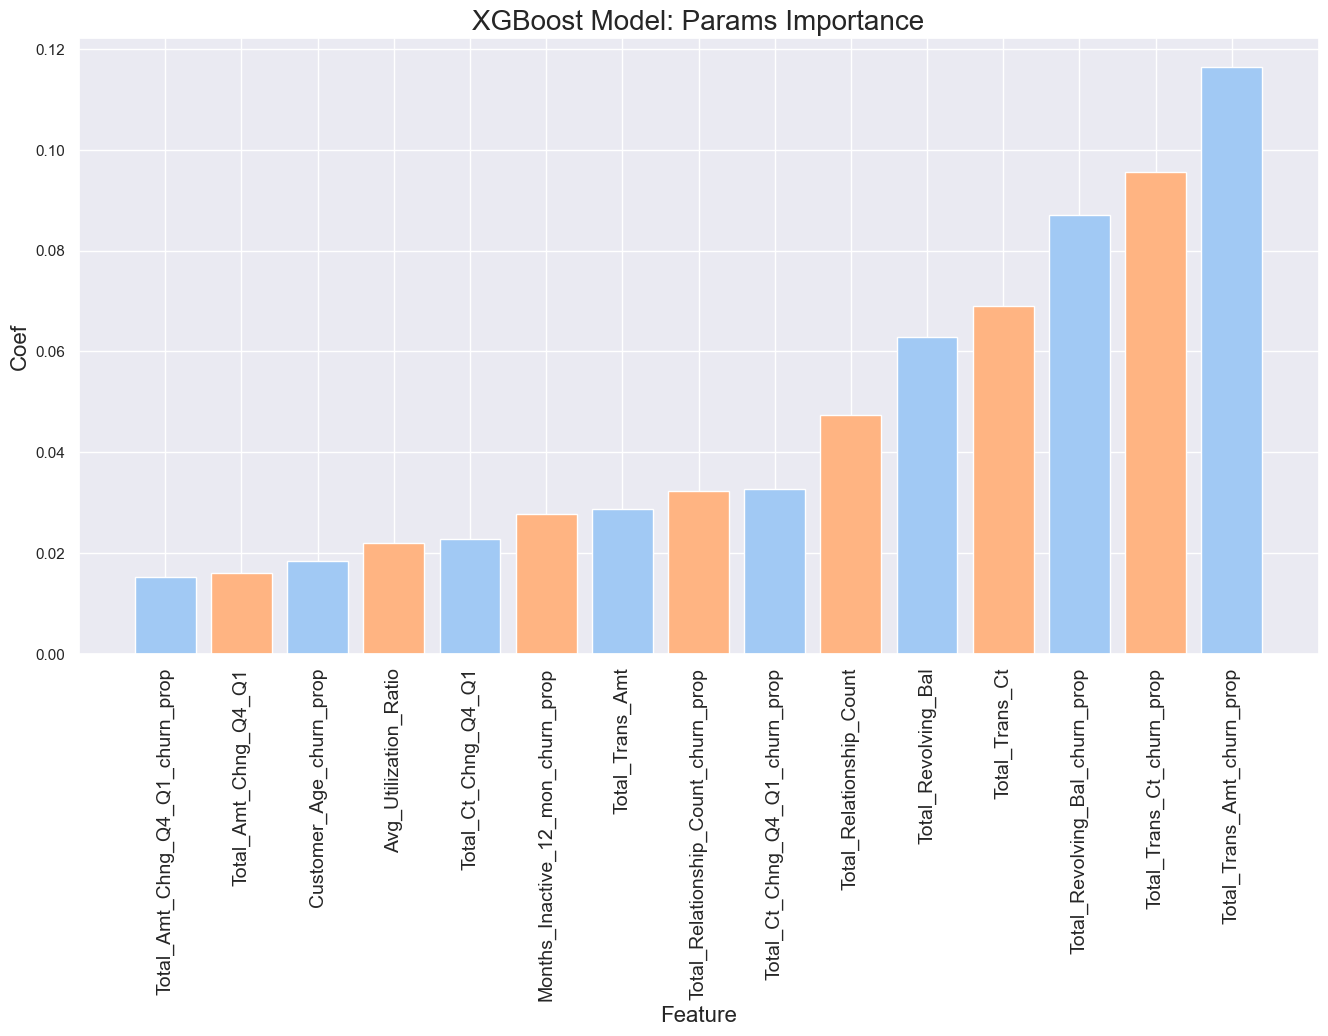

In [35]:
# Param Importance for the XGB model
xgb_params = pd.DataFrame({'features': xgb_best_model.feature_names_in_,
                           'importance': xgb_best_model.feature_importances_}
                         ).sort_values(by = 'importance')[-15:]
# Graphic size
fig = plt.figure(figsize = (16, 8))
# Seaborn Settings
sns.set()
# Feature Importance Plot
plt.bar(xgb_params.features,
        xgb_params.importance,
       color = sns.color_palette('pastel')[:2])    

# Labels
plt.title('XGBoost Model: Params Importance',
         fontsize = 20)
plt.xlabel('Feature',
           fontsize = 16)
plt.xticks(rotation = 90,
          fontsize = 14)
plt.ylabel('Coef',
           fontsize = 16)

plt.show()

The preceding graph displays the importance of features in predicting churn. It is evident that some of the most important variables were created during the preprocessing phase. In the following code, we will create a function to extract the actual names of the top 5 most important features as determined by the XGBoost model.

In [310]:
def important_features(df: pd.DataFrame, n: int) -> list:
    """ Get the 'n' most important features from the XGBoost model """
    # Get original featurs names
    df['features'] = df['features'].str.replace('_churn_prop', '') 
    # Get features sorted by importance
    columns = df.sort_values(by = 'importance', 
                             ascending = False)['features']
    # Get unique features
    unique_columns = list()
    [unique_columns.append(col) for col in columns if (col not in unique_columns) and col in data.columns]
    # Returns first 'n' features
    return unique_columns[:n]
    
# Get the 5 most important features from the xgboost model
most_important_features = important_features(xgb_params, 5)
print(most_important_features)

['Total_Trans_Amt', 'Total_Trans_Ct', 'Total_Revolving_Bal', 'Total_Relationship_Count', 'Total_Ct_Chng_Q4_Q1']


To get more information from the let's to get the coefficients from the logistic regression model:

In [37]:
# Get logistic model Coeficients and it's Features name
logistic_coef = dict((zip(logistic_best_model.feature_names_in_, logistic_best_model.coef_[0])))

# Show the most importants Features and their Coefficient
pd.DataFrame({(feature, round(coef, 2)) for (feature, coef) in logistic_coef.items() if feature in most_important_features},
            columns = ['feature','coef'])


feature  coef
0            Total_Trans_Ct -4.69
1       Total_Revolving_Bal -0.25
2  Total_Relationship_Count  0.03
3       Total_Ct_Chng_Q4_Q1 -4.45
4           Total_Trans_Amt  5.76

The logistic regression coefficients give information about the impact in the probability of churn:
- Total_Trans_Amt (5.76): For each additional transaction amount , the probability of churn increases.

- Total_Relationship_Count (0.03):  Each additional unit in the number of products held by the customers has a minor, positive impact on the probability of churn, meaning it slightly increase the likelihood.

- Total_Revolving_Bal (-0.25): Each additional unit in the revolving balance has a minor, negative impact on the probability of churn, meaning it slightly decreases the likelihood.

- Total_Trans_Ct (-4,69) and Total_Ct_Chng_Q4_Q1 (-4.45): For every decrease of 1 unit in the total transaction count or any change of it between Q4 and Q1, the probability of churn decreases significantly.


To conclude the analysis of the XGBoost model's results, I will make predictions for the entire dataset to identify the count of 'true positives,' 'true negatives,' 'false negatives,' and 'false positives.' These counts will be added as a new column to the dataset, creating a new DataFrame called 'X_results.' This DataFrame will include the original features, actual labels, model predictions, and the detailed results provided by the 'results_check()' function.

Next, I will create a 'pairplot' of the top 5 most important features for prediction, where each data point will be color-coded according to whether it represents a 'true positive,' 'true negative,' 'false negative,' or 'false positive.'

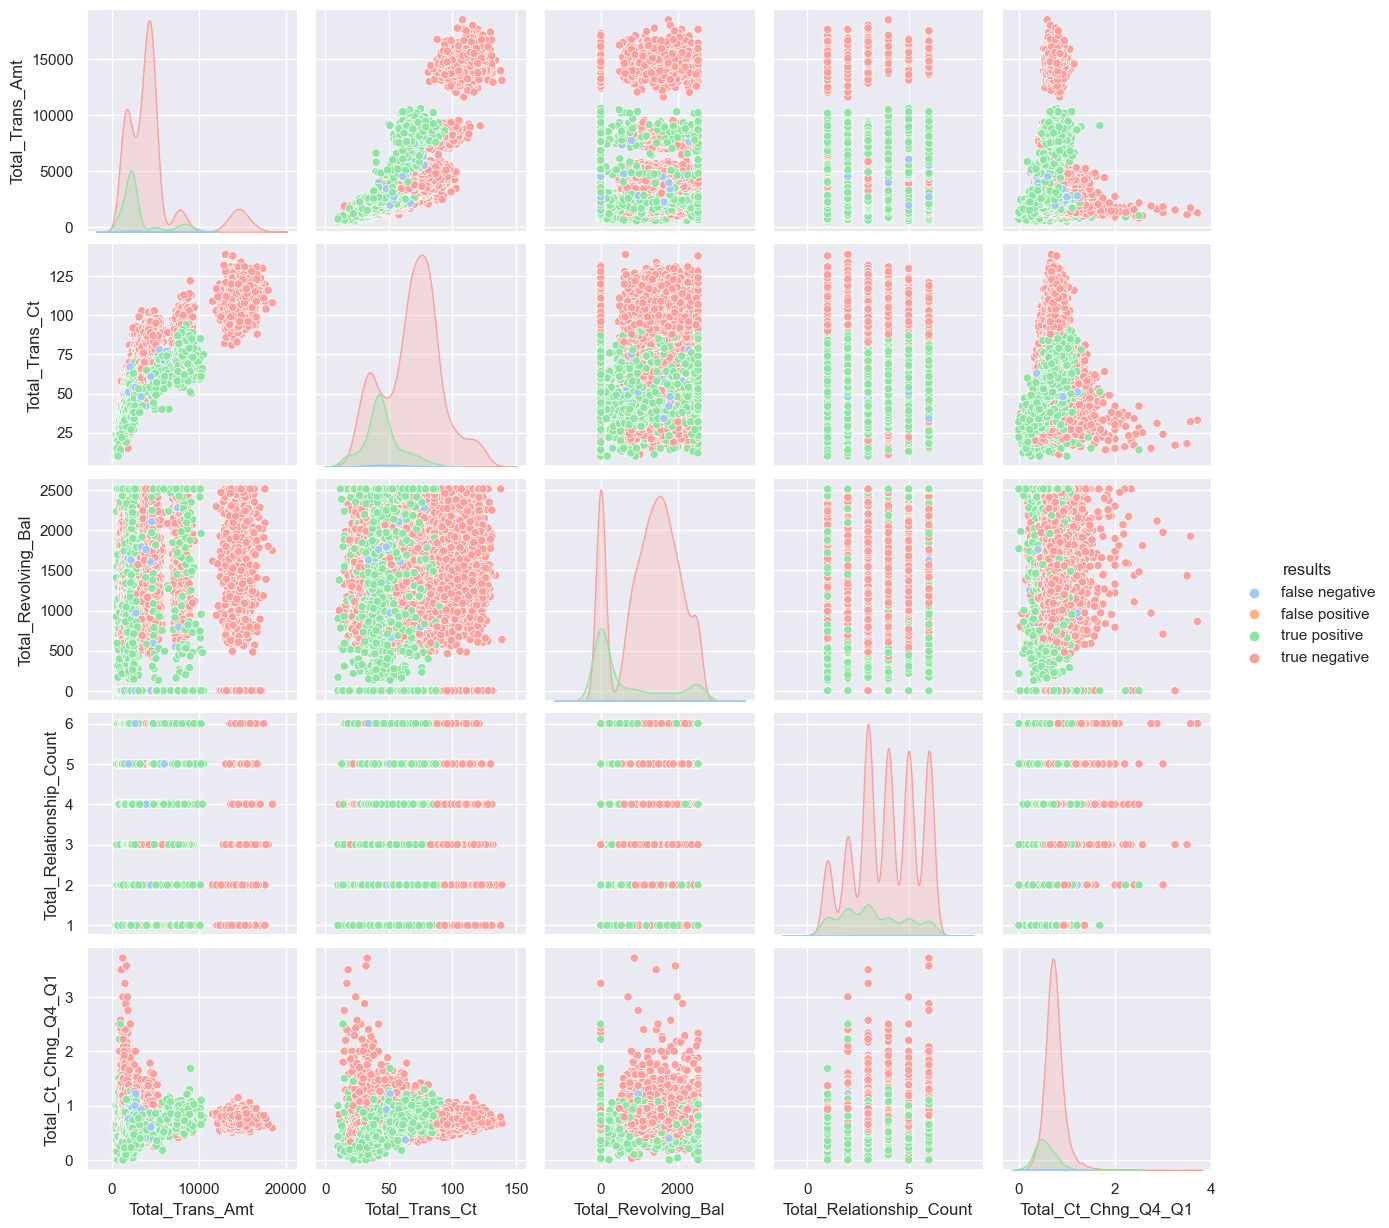

In [311]:
# Get predictions from the entire dataframe 'X'
pred = pd.Series(xgb_best_model.predict(X),
                 name = 'prediction',
                 index = X.index)

# Create X_results that includes original columns with the prediction
X_results = data.drop(y_col,
                      axis = 1).join([pred, y])

def results_check(x) -> str:
    """Return 'true positive', 'true negative', 'false negative' and 'false positive'
        given interaction of the real 'y' value and the prediction result """
    
    if (x['prediction'] == 1) & (x['Attrition_Flag'] == 1):
        return 'true positive'
    elif (x['prediction'] == 0) & (x['Attrition_Flag'] == 0):
        return 'true negative'
    elif (x['prediction'] == 0) & (x['Attrition_Flag'] == 1):
        return 'false negative'
    else:
        return 'false positive'
# Apply function to 'X_results' and save as a new column
X_results['results'] = X_results.apply(lambda x: results_check(x), axis = 1)
# Delete 'y_col' and 'prediction' from X_results
X_results.drop([y_col, 'prediction'],
               axis = 1,
               inplace = True)

sns.pairplot(X_results.query("results != 'false positive'")[most_important_features + ['results']], 
             hue = 'results',
            hue_order = ['false negative', 'false positive', 'true positive', 'true negative'] )
# Show the plot
plt.show()

The last graphics show the pairplot between the most important features in the XGBoost model, classified by the categories in a confusion matrix. 

The pairplot shows that 'false negatives' are located at the boundaries between 'true positives' and 'true negatives'. This suggests that 'false negatives' are cases where the model struggles to classify correctly due to their proximity to other categories. They are in an area of uncertainty, where the characteristics of these cases resemble both 'true positives' and 'true negatives', causing the model to make mistakes in not being able to clearly distinguish them.

